# MULTI AGENT AGAINST 5 STRATEGIES

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Import Data

In [2]:
validationdf = pd.read_csv("validation.csv")

#define the different agent strategies
constant_bid = pd.read_csv("constant_bidding.csv")
rand_range_bid = np.random.randint(100, 150, validationdf.shape[0])
lin_log_bid = pd.read_csv("linear_bidding_logreg.csv")
lin_xgb_bid = pd.read_csv("linear_bidding_xgb.csv")
nonlin_xgb = pd.read_csv("validation_best_NonLinear_bidding_price.csv")

In [3]:
def reset_order(agent_df):
    agent_df = agent_df.set_index('bidid')
    agent_df = agent_df.reindex(index=validationdf['bidid'])
    agent_df = agent_df.reset_index()
    return agent_df

In [4]:
constant_bid = reset_order(constant_bid)
lin_log_bid = reset_order(lin_log_bid)
lin_xgb_bid = reset_order(lin_xgb_bid)
nonlin_xgb = reset_order(nonlin_xgb)

In [40]:
###Multi-agent evaluation method###
import heapq

def evaluate_mult(agent_bids, budget = 6250000):
    agent_num = len(agent_bids)
    counter = 0
    clicks = [0] * agent_num
    imp =[0] * agent_num
    spent = [0] * agent_num
    agent_budget = [budget] * agent_num
    validationdf['Won_By_Agent'] = ""
    validationdf['Agent_Paid'] = ""

    while ((any(x > 0 for x in agent_budget)) & (counter < len(validationdf))):
        #assign current round of bids to one array
        curr_bids = [item[counter] for item in agent_bids]
        #check for budget; if agent runs out of budget, set current round's bid to 0
        for i in range(agent_num):
            #set their bid to 0 if they run out of budget
            if agent_budget[i] <= 0:
                curr_bids[i] = 0

                            

        if(any(y >= validationdf['payprice'][counter] for y in curr_bids)):
            #add payprice to list of bid prices to compare
            curr_bids.append(validationdf['payprice'][counter])
            
            winner_index = curr_bids.index(max(curr_bids))
            scnd_largest_bid = heapq.nlargest(2, curr_bids)[1]
            
            #deduct second price from winning bid's budget
            agent_budget[winner_index] -= scnd_largest_bid
            #return bid results
            clicks[winner_index] += validationdf['click'][counter]
            spent[winner_index] += scnd_largest_bid
            imp[winner_index] += 1
            validationdf.loc[counter, 'Won_By_Agent']= winner_index
            validationdf.loc[counter, 'Agent_Paid']= scnd_largest_bid
        counter += 1
    
    return clicks, spent, imp

In [6]:
def print_results(evaluation):
    agent_num = len(evaluation[0])
    
    agents_ctr = [0] * agent_num
    agents_cpm = [0] * agent_num
    agents_cpc = [0] * agent_num
    agents_spent = [0] * agent_num
    
    for i in range(agent_num):
        if(evaluation[2][i] == 0):
            agents_ctr[i] = 0
            agents_cpm[i] = 0
            agents_cpc[i] = 0
        else:
            agents_ctr[i] = evaluation[0][i] / evaluation[2][i]
            agents_cpm[i] = evaluation[1][i] / evaluation[2][i]
            agents_cpc[i] = evaluation[1][i] / evaluation[0][i] / 1000
            agents_spent[i] = round(evaluation[1][i]/6250000 *100)
    
    print("Agent clicks: ", evaluation[0])
    print("Agent spending: ", evaluation[1])
    print("Agent impressions: ", evaluation[2])
    print("Agent CTRs: ", agents_ctr)
    print("Agent CPMs: ", agents_cpm)
    print("Agent CPCs: ", agents_cpc)
    
    return evaluation[0], agents_spent, evaluation[2], agents_ctr, agents_cpm, agents_cpc

In [41]:
agents = [constant_bid.iloc[:, 1], rand_range_bid, lin_log_bid.iloc[:, 1], lin_xgb_bid.iloc[:, 1], nonlin_xgb.iloc[:, 1]]

print("Number of agents is %s" % len(agents))
results = print_results(evaluate_mult(agents))
#validationdf 

Number of agents is 5
Agent clicks:  [16, 7, 38, 108, 1]
Agent spending:  [6250068.0, 6250010.0, 3649434.0, 6250413.0, 35880.0]
Agent impressions:  [95301, 59659, 39264, 33786, 1291]
Agent CTRs:  [0.00016788910924334476, 0.00011733351212725657, 0.0009678076609616952, 0.0031965903036760787, 0.000774593338497289]
Agent CPMs:  [65.58239682689583, 104.76223201863927, 92.94605745721272, 185.0000887941751, 27.792408985282727]
Agent CPCs:  [390.62925, 892.8585714285715, 96.03773684210526, 57.87419444444445, 35.88]


In [45]:
validationdf.head(100)

Text(0.5,1,'Multi Agent Click Count')

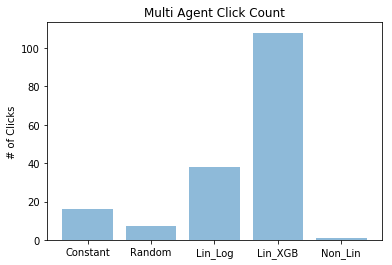

In [77]:
objects = ('Constant', 'Random', 'Lin_Log', 'Lin_XGB', 'Non_Lin')
y_pos = np.arange(len(objects))
performance = results[0]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('# of Clicks')
plt.title('Multi Agent Click Count')

Text(0.5,1,'Multi Agent Impression Count')

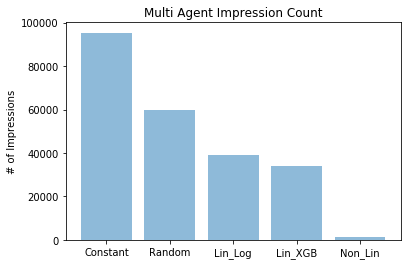

In [78]:
objects = ('Constant', 'Random', 'Lin_Log', 'Lin_XGB', 'Non_Lin')
y_pos = np.arange(len(objects))
performance = results[2]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('# of Impressions')
plt.title('Multi Agent Impression Count')

In [76]:
resultdf = validationdf[['Won_By_Agent','Agent_Paid']]
resultdf = resultdf[resultdf.Won_By_Agent != '']
resultdf['Agent_Paid'] = resultdf['Agent_Paid'].astype(int)
resultdf

,Won_By_Agent,Agent_Paid
0,1,103
1,1,103
2,0,100
3,0,102
4,1,103
5,1,103
6,1,103
7,1,103
8,1,103
9,1,103


([<matplotlib.axis.XTick at 0x1ae025597f0>,
 <a list of 5 Text xticklabel objects>)

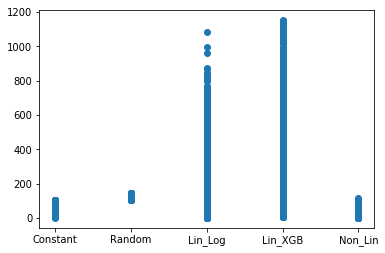

In [69]:
#'Won_By_Agent', 'Agent_Paid'
plt.scatter(x=resultdf['Won_By_Agent'], y=resultdf['Agent_Paid'])
objects = ('Constant', 'Random', 'Lin_Log', 'Lin_XGB', 'Non_Lin')
y_pos = np.arange(len(objects))
plt.xticks(y_pos, objects)